In [1]:
# Dependencies
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import random

from torchvision.models.resnet import resnet50, ResNet50_Weights

In [2]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# set random seeds for repeatability

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

seed_val = 0
set_seed(seed_val)

In [4]:
# Directories location
HOME_FOLDER = 'Home/' 
DATA_FOLDER = HOME_FOLDER + 'dataset/'
IMAGE_FOLDER = DATA_FOLDER + 'images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [5]:
# Dataframes
df_train = pd.read_csv(DATA_FOLDER + 'train_image_data.csv')
df_val = pd.read_csv(DATA_FOLDER + 'val_image_data.csv')
df_test = pd.read_csv(DATA_FOLDER + 'test_image_data.csv')


Index: 6311
Label: Blue
Text: tupperware


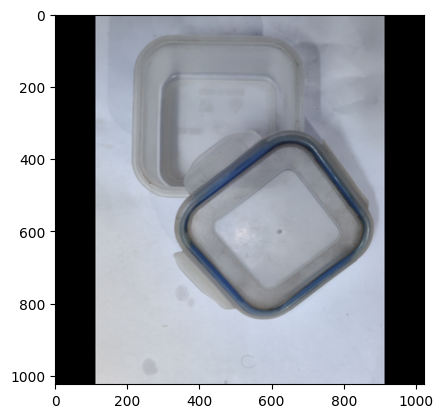

In [6]:
# Example

def show_sample(row_num):
    sample_row = df_train.iloc[row_num]
    print('Index:', row_num)
    print('Label:', sample_row['label'])
    print('Text:', sample_row['text'])
    image_path = IMAGE_FOLDER + sample_row['img_path']
    im = Image.open(image_path)
    plt.imshow(im)

from random import randint
show_sample(randint(0, len(df_train)))

In [7]:
# Classes assignment
label_to_id = {lab:i for i, lab in enumerate(df_train['label'].sort_values().unique())}
id_to_label = {v:k for k,v in label_to_id.items()}
num_out_labels = len(label_to_id)

print("label id dictionary", label_to_id)
print("number of labels: ", num_out_labels)

label id dictionary {'Black': 0, 'Blue': 1, 'Green': 2, 'TTR': 3}
number of labels:  4


In [8]:
# training parameters to be used for all models ##
num_train_epochs = 30
batch_size = 128
learning_rate = 1.0e-4
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

In [9]:
# Dataset loader

class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)

        # ADD DATA AUGMENTATION
        self.train_transform_func = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=15),  
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std)
            ]
        )

        # Evaluation
        self.eval_transform_func = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(self.img_size),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std)
            ]
        )

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]

        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")  # Convert to RGB

        if self.train:
            img = self.train_transform_func(image)
        else:
            img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]


In [10]:
# extract layers of resnet-50 to build a new model


class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)


    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [11]:
# Transfer learning from bert
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [12]:
# last output layer name for resnet is named 'layer4', dim 2048*7*7
# last layer name before fc is named 'avgpool', dim 2048*1*1 -> needs to be flattened
# reference: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b

class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% dropout rate
        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        #img_feature = self.visual_encoder(image)
        img_feature = self.visual_encoder(image).view(image.size(0), -1)  # Flatten image features
        features = torch.cat((text_feature, img_feature), 1)
        features = self.dropout(features)  # Apply dropout
        logits = self.classifier(features)

        return logits

In [13]:
# Initialize Bert-Resnet model
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

In [14]:
## training loop
set_seed(seed_val)

train_dataset = ResNetDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)        
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()


# Define validation dataset and dataloader
val_dataset = ResNetDataset(df=df_val, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Initialize a variable to track the best validation loss
best_val_loss = float("inf")

#early stop
patience = 3    # By experience of this dataset, patience of 3 is enough to avoid overfitting and save more resources of training time
patience_counter = 0    # Start the patience counter


start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    resnet_model.train()
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels, b_imgs = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()        
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        
        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()
        
    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])




    # Validation Phase
    resnet_model.eval()
    val_loss = 0
    
    correct_predictions = 0  # Track correct predictions
    total_samples = 0  # Track total number of samples
    
    with torch.no_grad():
        for batch in val_dataloader:
            b_text, b_labels, b_imgs = batch
            b_inputs = bert_tokenizer(
                list(b_text), truncation=True, max_length=max_seq_length,
                return_tensors="pt", padding=True
            )
            
            b_labels = b_labels.to(device)
            b_imgs = b_imgs.to(device)
            b_inputs = b_inputs.to(device)

            b_logits = resnet_model(text=b_inputs, image=b_imgs)
            val_loss += criterion(b_logits, b_labels).item()
            
            
            #calculate accuracy
            _, preds = torch.max(b_logits, dim=1)  # Get predicted class
            correct_predictions += (preds == b_labels).sum().item()
            total_samples += b_labels.size(0)
            
            
            
    val_accuracy = correct_predictions / total_samples
    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch_num}: Validation Loss = {avg_val_loss:.4f}')
    print(f'Epoch {epoch_num}: Validation Accuracy = {val_accuracy:.4f}')
    
    

    # Check if this is the best model so far based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 #reset counter
        torch.save(resnet_model.state_dict(), "best_model.pt")  
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

    else:
        patience_counter += 1
        print(f'No improvement, patience counter: {patience_counter}/{patience}')
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch_num}')
        break




end = perf_counter()
resnet_training_time = end - start
print('Training completed in ', resnet_training_time, 'seconds')

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/80 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 38.785708129405975
    avg_epoch_loss = 0.48482135161757467
    learning rate = 9.972609476841367e-05
Epoch 0: Validation Loss = 0.3305
Epoch 0: Validation Accuracy = 0.8883
Best model saved with validation loss: 0.3305


Batch:   0%|          | 0/80 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 18.397566698491573
    avg_epoch_loss = 0.22996958373114468
    learning rate = 9.890738003669029e-05
Epoch 1: Validation Loss = 0.3284
Epoch 1: Validation Accuracy = 0.8978
Best model saved with validation loss: 0.3284


Batch:   0%|          | 0/80 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 12.399688690900803
    avg_epoch_loss = 0.15499610863626004
    learning rate = 9.755282581475769e-05
Epoch 2: Validation Loss = 0.3194
Epoch 2: Validation Accuracy = 0.9039
Best model saved with validation loss: 0.3194


Batch:   0%|          | 0/80 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 8.551344968378544
    avg_epoch_loss = 0.1068918121047318
    learning rate = 9.567727288213005e-05
Epoch 3: Validation Loss = 0.3284
Epoch 3: Validation Accuracy = 0.8967
No improvement, patience counter: 1/3


Batch:   0%|          | 0/80 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 6.705954723060131
    avg_epoch_loss = 0.08382443403825164
    learning rate = 9.330127018922194e-05
Epoch 4: Validation Loss = 0.4041
Epoch 4: Validation Accuracy = 0.8889
No improvement, patience counter: 2/3


Batch:   0%|          | 0/80 [00:00<?, ?it/s]

epoch = 5
    epoch_loss = 5.046563617885113
    avg_epoch_loss = 0.0630820452235639
    learning rate = 9.045084971874738e-05
Epoch 5: Validation Loss = 0.3850
Epoch 5: Validation Accuracy = 0.9022
No improvement, patience counter: 3/3
Early stopping triggered at epoch 5
Training completed in  11699.585766000004 seconds


In [15]:
# testing loop

resnet_model.load_state_dict(torch.load("best_model.pt", map_location=device, weights_only=True)) #uncomment if we just want to test the data without retraining

resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)

#Prediction
for batch in tqdm(test_dataloader):
    resnet_model.eval()

    b_text, b_labels, b_imgs = batch

    b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

    b_labels = b_labels.to(device)
    b_imgs = b_imgs.to(device)
    b_inputs = b_inputs.to(device)

    with torch.no_grad():
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        b_logits = b_logits.detach().cpu()

    resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

# prediction labels
resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]

  0%|          | 0/27 [00:00<?, ?it/s]

In [16]:
resnet_class_report = classification_report(df_test['label'], resnet_prediction_labels, output_dict=True)

# Save overall results to json file
with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

# Examine the accuracy of the testing result
print(resnet_class_report['accuracy'])

0.8417371028854561


In [17]:
## This is to predict a single image
# Input: the description (name of the image file without the extension) and image file path
# Output: the label code 'Black': 0, 'Blue': 1, 'Green': 2, 'TTR': 3

# Load tokenizer and define device
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinitialize model architecture and load weights
num_labels = 4  # Adjust based on your task
model = BertResNetModel(num_labels=num_labels).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device, weights_only=True))
model.eval()  # Set to evaluation mode

# Define image transformations
img_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# Prediction function
def predict(text, img_path):
    # Tokenize and process the text input
    inputs = bert_tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    
    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")
    image = img_transforms(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        logits = model(text=inputs, image=image)
        prediction = logits.argmax(dim=1).item()  # Get predicted label
    
    return prediction

# Example usage
sample_text = "expired rotten_apple compostable"
sample_img_path = "Home/dataset/images/expired_rotten_apple_compostable_1187.png"  # Provide the actual path to an image file
predicted_label = predict(sample_text, sample_img_path)
print("Predicted label:", predicted_label)


Predicted label: 2


In [18]:
## This is to save the prediction, truth data in the whole testing dataset
from tqdm import tqdm

# Load the test dataset
test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the best model
resnet_model = BertResNetModel(num_labels=len(label_to_id))
resnet_model.load_state_dict(torch.load("best_model.pt", weights_only=True))
resnet_model.to(device)
resnet_model.eval()

# Initialize lists to store results
img_paths = []
predictions = []
truths = []

# Run inference on the test dataset
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        # Get model predictions
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        _, preds = torch.max(b_logits, dim=1)
        
        # Store results
        img_paths.extend(test_dataset.df['img_path'][len(img_paths):len(img_paths) + len(preds)].tolist())
        predictions.extend(preds.cpu().tolist())
        truths.extend(b_labels.cpu().tolist())

# Convert label IDs back to label names
id_to_label = {v: k for k, v in label_to_id.items()}
predictions = [id_to_label[p] for p in predictions]
truths = [id_to_label[t] for t in truths]

# Save results to CSV
results_df = pd.DataFrame({
    "img_path": img_paths,
    "prediction": predictions,
    "truth": truths
})
results_df.to_csv("test_results.csv", index=False)
print("Test results saved to test_results.csv")


Testing: 100%|██████████| 27/27 [06:01<00:00, 13.41s/it]

Test results saved to test_results.csv
